C:\Users\DavidShin\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


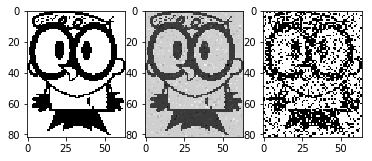

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
import scipy.stats as stats
import copy


def add_gaussian_noise(im,prop,varSigma):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    e = varSigma*np.random.randn(np.prod(im.shape)).reshape(im.shape)
    im2 = np.copy(im).astype('float')
    im2[index] += e[index]
    return im2

def add_saltnpeppar_noise(im,prop):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    im2 = np.copy(im)
    im2[index] = 1-im2[index]
    return im2

def binaryImage(image):
    cp_image = copy.deepcopy(image)
    for x in range(len(cp_image)):
        for y in range(len(cp_image[0])):
            cp_image[x][y] = round(cp_image[x][y])
    return cp_image
# proportion of pixels to alter

prop = 0.2
varSigma = 0.1
im = misc.imread('images/dexter.jpg')
im = im/255
im = binaryImage(im)
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(im,cmap='gray')
im2 = add_gaussian_noise(im,prop,varSigma)
ax2 = fig.add_subplot(132)
ax2.imshow(im2,cmap='gray')
im3 = add_saltnpeppar_noise(im,prop)
ax3 = fig.add_subplot(133)
ax3.imshow(im3,cmap='gray')
print(im)

In [2]:
def neighbours(i,j,M,N,size=4):
    if size==4:
        if (i==0 and j==0):
            n=[(0,1), (1,0)]
        elif i==0 and j==N-1:
            n=[(0,N-2), (1,N-1)]
        elif i==M-1 and j==0:
            n=[(M-1,1), (M-2,0)]
        elif i==M-1 and j==N-1:
            n=[(M-1,N-2), (M-2,N-1)]
        elif i==0:
            n=[(0,j-1), (0,j+1), (1,j)]
        elif i==M-1:
            n=[(M-1,j-1), (M-1,j+1), (M-2,j)]
        elif j==0:
            n=[(i-1,0), (i+1,0), (i,1)]
        elif j==N-1:
            n=[(i-1,N-1), (i+1,N-1), (i,N-2)]
        else:
            n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
        return n
    if size==8:
        print('Not yet implemented\n')
        return -1

In [3]:
def calculateEnergy(latent, noisy, i, j, beta, eta):
    n = neighbours(i, j, latent.shape[0], latent.shape[1])
    energy = eta*(latent[i][j]*noisy[i][j])
    for m in n:
        x, y = m
        energy += beta * latent[x][y] * latent[i][j]
    return energy

def convertLatent(latent):
    for i in range(latent.shape[0]):
        for j in range(latent.shape[1]):
            if latent[i][j] == 0:
                latent[i][j] = -1
    return latent
    
def ICM(image, beta, eta, runs):
    latentImage = copy.deepcopy(image)
    latentImage = convertLatent(latentImage)
    for n in range(runs):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                bros = neighbours(i, j, latentImage.shape[0], latentImage.shape[1])
                latentImage[i][j] = 1
                posEnergy = calculateEnergy(latentImage, image, i,j, beta, eta)
                for m in bros:
                    x, y = m
                    posEnergy += calculateEnergy(latentImage, image, x, y, beta, eta)
                latentImage[i][j] = -1
                negEnergy = calculateEnergy(latentImage, image, i,j, beta, eta)
                for m in bros:
                    x, y = m
                    negEnergy += calculateEnergy(latentImage, image, x, y, beta, eta)
                if posEnergy > negEnergy:
                    latentImage[i][j] = 1
                else:
                    latentImage[i][j] = -1
    return latentImage

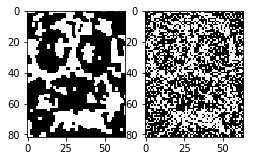

In [4]:
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(ICM(im3, 0.4, 1, 5),cmap='gray')
ax2 = fig.add_subplot(132)
ax2.imshow(im3,cmap='gray')

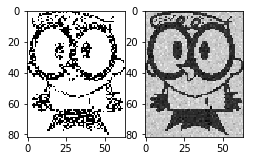

In [5]:
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(ICM(im2, 0, 1, 1),cmap='gray')
ax2 = fig.add_subplot(132)
ax2.imshow(im2,cmap='gray')

In [73]:
def gibbs(image, beta, eta, runs):
    latentImage = copy.deepcopy(image)
    latentImage = convertLatent(latentImage)
    previosLatent = copy.deepcopy(latentImage)
    for n in range(runs):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                bros = neighbours(i, j, latentImage.shape[0], latentImage.shape[1])
                latentImage[i][j] = previosLatent[i][j] * -1
#                 preEnergy = calculateEnergy(previosLatent, image, i, j, beta, eta)
                posEnergy = calculateEnergy(latentImage, image, i,j, beta, eta)
                
                for m in bros:
                    x, y = m
                    posEnergy += calculateEnergy(latentImage, image, x, y, beta, eta)
#                     preEnergy += calculateEnergy(previosLatent, image, x, y, beta, eta)
                
#                 preEnergy = np.exp(preEnergy)
                posEnergy = np.exp(posEnergy)
#                 posAcceptance = np.amin(np.array([1, posEnergy/preEnergy ]))
#                 latentImage[i][j] = -1
#                 negEnergy = calculateEnergy(latentImage, image, i,j, beta, eta)
                
#                 for m in bros:
#                     x, y = m
#                     negEnergy += calculateEnergy(latentImage, image, x, y, beta, eta)
                   
#                 negEnergy = np.exp(negEnergy)
#                 posAcceptance = posEnergy/(posEnergy + negEnergy)
#                 negAcceptance = negEnergy/(posEnergy + negEnergy)
                
                r = np.random.uniform(0,1)
                
                if posEnergy > r:
                    previosLatent[i][j] = previosLatent[i][j] * -1
#                 else:
#                     latentImage[i][j] = 1
#                 if posAcceptance > r and negAcceptance <= r:
#                     latentImage[i][j] = 1
#                 elif posAcceptance <= r and negAcceptance > r:
#                     latentImage[i][j] = -1
#                 elif posAcceptance > r and negAcceptance > r:
#                     if posAcceptance > negAcceptance:
#                         latentImage[i][j] = 1
#                     else:
#                         latentImage[i][j] = -1
#                 elif posAcceptance <= r and negAcceptance <= r:
#                     latentImage[i][j] = previosLatent[i][j]
                    
#                 previosLatent = copy.deepcopy(latentImage)
                
    return latentImage

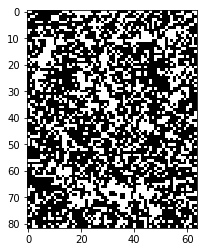

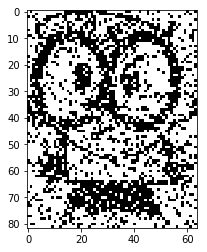

In [88]:
## fig = plt.figure()
# ax = fig.add_subplot(131)
plt.imshow(gibbs(im3, 0.2, 1, 3),cmap='gray')
plt.show()
# ax2 = fig.add_subplot(132)
plt.imshow(im3,cmap='gray')
plt.show()

In [89]:
def sigm(val):
    return 1/(1+np.exp(-2*val))

def tanh(val):
    return (np.exp(val) - np.exp(val * -1)) / (np.exp(val) + np.exp(val * -1))

# def m(weight, i, j, image):
#     bro = neighbours(i, j, image.shape[0], image.shape[1])
    
#     m_val = 0
#     for x, y in bro:
#         m_val += weight * tanh()

In [ ]:
def VB(image, runs, weight):
    mu = np.zeros((image.shape[0], image.shape[1]))
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            mu[i][j] = np.random.uniform(0, 1)
            
    latentImage = copy.deepcopy(image)
    
    for k in range(runs):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                bros = neighbours(i, j, latentImage.shape[0], latentImage.shape[1])
                
                m_val = 0
                for x, y in bros:
                    m_val += weight * mu[x][y]
                
                mu_val = tanh(m_val + 0.5 * ())

C:\Users\DavidShin\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


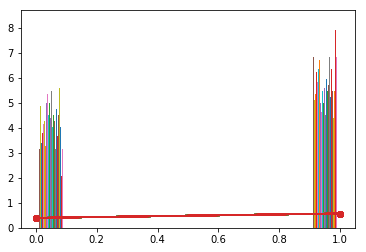

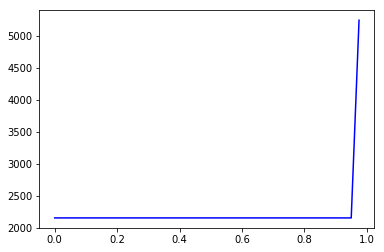

In [105]:
test = stats.norm.pdf(im3, np.mean(im3), np.std(im3))

plt.plot(im3, test, '-o')

plt.hist(im3,normed=True)      #use this to draw histogram of your data

plt.show()

test_image = copy.deepcopy(im3)
test_image[10][10] *= -1

values, base = np.histogram(test_image, bins = 40)

cumulative = np.cumsum(values)

plt.plot(base[:-1], cumulative, c='blue')
